### TODO: Add more markdown to this file.

Add some markdown here.

The functions in this notebook have been arranged lexicographcally, which helps me organize complex work in a way that makes sense to me.  I have given a rational for the existence of each function in a markdown cell above its definition, and indicated where and when it can expect to be called.

The project has a complex way of managing its IRS data files.  The IRS data files are indexed by ZIP code, but contain data for the entire USA.  On first run, the project code will read the income data for the whole USA, isolate data for the state of New York, then write that out as a separate data file for subsequent use.  Next, the project code will use the ZIP codes obtained from the New York City demographic data to further isolate the New York state income data for *only* the city of New York.  It will also write out **that** for subsequent use.  So isolating the income data for New York City is a two-step process.  Therefore, this method will create four derived csv files in its IRS directory: ny_agi.csv, nyc_agi.csv, nyc_no_agi.csv, and ny_no_agi.csv.  These are: New York State income data w/AGI, New York City income data w/AGI, New York State income data without AGI, and New York City income data without AGI.  If the project code is run more than once, then it will attempt to reuse the derived files that it had previously created.

Firstly, here are the imports:

In [114]:
"""
Analysis of New York City Income Data Versus Ethnicity
"""
import os

import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib.ticker as ticker

import numpy as np
import pandas as pd

from sklearn import linear_model

Next, I declare constants that will be used throughout the remainder of the code.  These include file names, keys for plotting, column name constants, and file paths.

In [115]:
# Declare and initialize file names.
DEMOGRAPHICS_FILENAME = 'Demographic_Statistics_By_Zip_Code.csv'
NY_WITH_AGI_FILENAME = 'ny_agi.csv'
NY_WITHOUT_AGI_FILENAME = 'ny_no_agi.csv'
NYC_WITH_AGI_FILENAME = 'nyc_agi.csv'
NYC_WITHOUT_AGI_FILENAME = 'nyc_no_agi.csv'
WITH_AGI_FILENAME = '15zpallagi.csv'
WITHOUT_AGI_FILENAME = '15zpallnoagi.csv'

# Declare and initialize dictionary keys for plotting.
COLOR_KEY = 'color_key'
ETHNICITY_KEY = 'ethnicity_key'
LESS_KEY = 'less_key'
MORE_KEY = 'more_key'

# Declare and initialize demographic data constants.
AFRICAN = 'african'
CAUCASIAN = 'caucasian'
LATINO = 'latino'
PCNT_AFRICAN = 'pcnt_african'
PCNT_CAUCASIAN = 'pcnt_caucasian'
PCNT_LATINO = 'pcnt_latino'
STATE = 'NY'
ZIP_CODE = 'zip_code'

# Declare and initialize no-AGI income data columns
AVERAGE_INCOME = 'average_income'
RETURN_COUNT = 'number_of_returns'
TOTAL_INCOME = 'total_income_thsnds'

# Declare and initialize paths.
UW_PATH = os.path.join(os.sep, 'home', 'gary', 'UW Data Science',
                       'DATA 512', 'Project')
PYCHARM_PATH = os.path.join(os.sep, 'home', 'gary',
                            'PycharmProjects', 'NYC_Study')
PROJECT_PATH = PYCHARM_PATH
IRS_PATH = os.path.join(PROJECT_PATH, "IRS")
NYC_PATH = os.path.join(PROJECT_PATH, "NYC")

The function create_subset() is called in run_study(), the top level function.  In this function, I create a subset of the entirety of the New York City demographic data.  In the entirety of the demographic data there are columns for all race-based groups in the city.  For the subset, I wish to isolate only two: either African American versus Caucasian, African American versus Latino, or Caucasian versus Latino.  This function does that.  It removes all rows where both groups have zero representatives.  Next, it calculates the number of members of the first group as a fraction of the number of members of both groups, and then calculates the inverse of that.  It returns the thusly created subset.

In [116]:
def create_subset(data_frame, count_column_1, count_column_2, pcnt_column_1, pcnt_column_2):
    """
    Creates a subset of a data frame.

    :param data_frame: The data frame from which a subset will be drawn
    :type data_frame: pandas.core.frame.DataFrame
    :param count_column_1: The name of the first column
    :type count_column_1: str
    :param count_column_2: The name of the second column
    :type count_column_2: str
    :param pcnt_column_1: The name of the first percent column
    :type pcnt_column_1: str
    :param pcnt_column_2: The name of the second percent column
    :type pcnt_column_2: str
    :return: A data frame in which one or both of the values in the first
    or second columns is greater than zero, and in which columns for the
    fraction of values first versus second, and second versus first have
    been added
    :rtype: pandas.core.frame.DataFrame
    """

    # Retain only rows where either the value in the first column or the
    # value in the second column is greater than zero.
    target_value = 0
    subset = pd.DataFrame(
        data_frame[(data_frame[count_column_1] > target_value) |
                   (data_frame[count_column_2] > target_value)])

    # Create the two percentage columns and return the resulting data frame.
    subset[pcnt_column_1] = determine_percentage(subset[count_column_1],
                                                 subset[count_column_2])
    subset[pcnt_column_2] = 1. - subset[pcnt_column_1]
    return subset

The function create_model() is also called directly from run_study(), the top level function.  Given a data frame, the function creates a linear model from the first named column to the second.  Obviously, the given data frame must contained both named columns.

In [117]:
def create_model(data_frame, column_1, column_2):
    """
    Creates a linear model.

    :param data_frame: The data frame containing the values to model
    :type data_frame: pandas.core.frame.DataFrame
    :param column_1: The name of the 'x' column
    :type column_1: str
    :param column_2: The name of the 'y' column
    :type column_2: str
    :return: A linear model of the second column by the first
    :rtype: sklearn.linear_model.LinearRegression
    """

    # Determine the number of rows in the frame, and create the model.
    length = len(data_frame)
    model = linear_model.LinearRegression()

    # Fit the model and return it.
    model.fit(data_frame[column_1].values.reshape(length, 1),
              data_frame[column_2].values.reshape(length, 1))
    return model

The function determine_percentage() is called from create_subset(), which is the function named two code cells above this one.  It is misnamed, because it is not calculating a percentage.  It is really calculating a fraction of the given numerator divided by the sum of the numerator and the 'other'.  There is probably a much more elegant way to do this, but I have been programming in Python for not much more than six months.

In [118]:
def determine_percentage(numerator, other):
    """
    Determines a fraction.

    :param numerator: The numerator of the calculation
    :type numerator: int
    :param other: The values that will be added to the numerator to
    calculate the denominator
    :type other: int
    :return: The fraction of the numerator divided by the sum of the two
    arguments
    :rtype: int
    """
    return numerator / (numerator + other)

The function format_coefficient() is called in run_study(), the top level function.  It is used to format a linear model coefficient so that it can be displayed in the title of a plot.  I have asked for a format with a comma as a thousands separator, and I have rounded the coefficient (or slope) to two places.

In [119]:
def format_coefficient(model):
    """
    Formats the coefficient of a model for display.

    :param model: A linear model
    :type model: sklearn.linear_model.LinearRegression
    :return: The formatted coefficient
    :rtype: str
    """
    return "{:,}".format(round(model.coef_.tolist()[0][0], 2))

The function format_money() is called in the functions plot_lines() and plot_model().  What it's doing is formating the value used in the 'y' axis of the plots for U.S. dollar monetary values.  The values will be shown with a dollar sign, a thousands separator, and no numbers after the decimal point.

In [120]:
def format_money(amount, pos):
    """
    Formats money for the 'y' axis of a plot.

    :param amount: The amount
    :type amount: int
    :param pos: The position argument
    :type pos: int
    :return: A formatted money string
    :rtype: str
    """
    # pylint: disable=unused-argument
    return '${:,.0f}'.format(amount)

The function format_percentage() is also called in plot_lines() and plot_model().  It is formatting the value used in the 'x' axis of the plots to show percentages (like percent Caucasian versus African American).  The values will be shown with a preceeding '%', and no numbers after the decimal point.

In [121]:
def format_percent(percentage, pos):
    """
    Formats percentages for the 'x' axis of a plot.

    :param percentage: The fraction between 0.0 and 1.0
    :type percentage: float
    :param pos: The position argument
    :type pos: int
    :return: A formatted percentage string
    :rtype: str
    """
    # pylint: disable=unused-argument
    return '{:.0f}%'.format(percentage * 100.)

The function get_demographics() is called in get_demographic_data().  It is reading the unmodified NYC demographic data from a csv file.

In [122]:
def get_demographics():
    """
    Read demographic data for New York City.

    :return: A dataframe with demographic data for New York City.
    :rtype: pandas.core.frame.DataFrame
    """

    print(os.path.join(NYC_PATH, DEMOGRAPHICS_FILENAME))
    return pd.read_csv(os.path.join(NYC_PATH, DEMOGRAPHICS_FILENAME))

The function get_demographic_data() is called form perform_test(), and the top level method, run_study().  It gets and modifies demographic data from New York City.

In [123]:
def get_demographic_data():
    """
    Read demographic data for New York City and modifies it.

    :return: A dataframe with demographic data for New York City.
    :rtype: pandas.core.frame.DataFrame
    """
    return modify_demographic_data(get_demographics())

The function get_income_data_with_agi() is called from perform_test(), and is really a dead end as far the final product of this study goes. See, the IRS data came in two flavors: One, broken down with AGI buckets (e.g., up to \$25,000, from there to \$50,000, etc.), the other, unbucketed. I did not know when I began this study whether I would be using the bucketed or unbucketed data, but eventually used the unbucketed. So this function is only used in the perform_test() function that creates some notional statistics and plots. Like the function get_income_data_without_agi(), this function takes a list of ZIP codes. It will use the ZIP codes to screen the income rows to only those given ZIP codes.

Note how the function works. It first calls get_ny_with_agi() to get income data just for the state of New York. Then it calls get_nyc_with_agi() to isolate the New York City rows. Lastly, it calls modify_income_data_with_agi() to remove some features, and rename others.

In [124]:
def get_income_data_with_agi(zip_codes):
    """
    Gets income data with AGI for New York City, and modifies it.

    :param data_frame: A data frame containing a 'ZIPCODE' field
    :type data_frame: pandas.core.frame.DataFrame
    :param target_zipcodes: A collection of ZIP codes
    :type target_zipcodes: set or list-like
    :return: A data frame containing records with only the given ZIP code
    values
    :rtype: pandas.core.frame.DataFrame
    """

    data_frame = get_ny_with_agi()
    data_frame = get_nyc_with_agi(data_frame, zip_codes)
    return modify_income_data_with_agi(data_frame)

The function get_income_data_without_agi() is called in perform_test() (for notional results), and also in run_study(), the top level function.  It takes a list of ZIP codes to screen the income rows to *only* those given ZIP codes.

Note how the function works.  It first calles get_ny_without_agi() to get income data *just* for the state of New York.  Then it calls get_nyc_without_agi() to isolate the New York City rows.  Lastly, it calls modify_income_data_without_agi() to remove some features, and rename others. 

In [125]:
def get_income_data_without_agi(zip_codes):
    """
    Gets income data without AGI for New York city, and modifies it.

    :param zip_codes: Only include these ZIP codes
    :type zip_codes: list or tuple
    :return: A data frame containing records with only the give ZIP code
    :rtype: pandas.core.frame.DataFrame
    """

    data_frame = get_ny_without_agi()
    data_frame = get_nyc_without_agi(data_frame, zip_codes)
    return modify_income_data_without_agi(data_frame)

The function get_ny_common() is called by both get_ny_with_agi() and get_ny_without_agi().  It's reading the raw IRS income data for the state of New York, if it exists.  If it doesn't exist, this function is reading the raw IRS income data for the *whole* country, and then isolating the data for the state of New York before writing it out.  In this way the New York state data will not have to be isolated from the whole country more than once.

In [126]:
def get_ny_common(reduced_filename, whole_filename):
    """
    Gets income data for the state of New York.  Writes the existing data frame
    if it does not already exist, and returns it.

    :param reduced_filename: The name of the New York only data file
    :type reduced_filename: str
    :param whole_filename: The name of the all-USA data file
    :type whole_filename: str
    :return: A data frame containing income data only for the state of New York
    :rtype: pandas.core.frame.DataFrame
    """

    # Calculate the path of the reduced file.  Does the file already exist?
    reduced_filepath = os.path.join(IRS_PATH, reduced_filename)
    if os.path.isfile(reduced_filepath):

        # The file already exists.  Just read it.
        print('New York file already exists...')
        data_frame = pd.read_csv(reduced_filepath)

    else:

        # The file doesn't exist.  Create it.
        print('New York file does not exist; creating it...')
        data_frame = isolate(reduced_filepath,
                             pd.read_csv(os.path.join(IRS_PATH,
                                                      whole_filename)),
                             STATE)

    # Return the read, or newly created data frame.
    return data_frame

The function get_nyc_common() is called by both get_nyc_with_agi() and get_nyc_without_agi().  It is doing something very similar to get_ny_common() above, except that it is reading IRS income data for New York City, if it exists.  If it doesn't exist, this function is reading the IRS income data for the state of New York (and this was created in get_ny_with_agi(), or get_ny_without_agi()), and then isolating the data for New York City before writing it out.  In this way the New York City data will not have to be isolated from the state of New York more than once.

In [127]:
def get_nyc_common(reduced_filename, data_frame, target_zipcodes,
                   zipcode_fieldname='zipcode'):
    """
    Gets income data for the New York City.  Write the existing data frame
    if it does not already exist, and returns it.

    :param reduced_filename: The name of the New York City only data file
    :type reduced_filename: str
    :param data_frame: A dataframe containing income data to be screened
    :type data_frame: pandas.core.frame.DataFrame
    :param target_zipcodes: A collection of ZIP codes
    :type target_zipcodes: set or list-like
    :param zipcode_fieldname The name of the field in the data frame containing
    ZIP codes
    :type zipcode_fieldname str
    :return: A data frame containing income data only for the New York City
    :rtype: pandas.core.frame.DataFrame
    """

    reduced_filepath = os.path.join(IRS_PATH, reduced_filename)
    if os.path.isfile(reduced_filepath):

        print('New York City file already exists...')
        reduced_data_frame = pd.read_csv(reduced_filepath)

    else:

        print('New York City files does not exist; creating it...')
        reduced_data_frame = isolate_nyc(reduced_filepath,
                                         data_frame,
                                         target_zipcodes,
                                         zipcode_fieldname)

    return reduced_data_frame

The function get_ny_with_agi() is called from get_income_data_with_agi().  As mentioned for get_income_data_with_agi(), this function ends up being a dead end.  I ultimately ended up using the data *without* AGI.  The function gets income data with AGI only for the state of New York.  This function calls get_ny_common() to do its work.

In [128]:
def get_ny_with_agi():
    """
    Gets income data with AGI for the state of New York.  Writes the resulting
    data frame if it does not already exist, and returns it.

    :return: A data frame containing income data with AGI only for the state of
    New York
    :rtype: pandas.core.frame.DataFrame
    """

    return get_ny_common(NY_WITH_AGI_FILENAME, WITH_AGI_FILENAME)

The function get_ny_without_agi() is called from get_income_data_without_agi().  The function gets income data without AGI only for the state of New York.  This function calls get_ny_common to do its work.

In [129]:
def get_ny_without_agi():
    """
    Gets income data without AGI for the state of New York.  Writes the
    resulting data frame if it does not already exist, and returns it.

    :return: A data frame containing income data without AGI only for the state
    of New York
    :rtype: pandas.core.frame.DataFrame
    """

    return get_ny_common(NY_WITHOUT_AGI_FILENAME, WITHOUT_AGI_FILENAME)

The function get_nyc_with_agi() is called by get_income_data_with_agi().  As mentioned for get_income_data_with_agi(), this function ends up being a dead end.  I ultimately ended up using the data *without* AGI.  The function gets income data with AGI only for New York City.  This function calls get_nyc_common() to do its work.

In [130]:
def get_nyc_with_agi(data_frame, target_zipcodes):
    """
    Gets income data with AGI for New York City.  Writes the resulting
    data frame if it does not already exist, and returns it.

    :param data_frame: A data frame containing a 'ZIPCODE' field
    :type data_frame: pandas.core.frame.DataFrame
    :param target_zipcodes: A collection of ZIP codes
    :type target_zipcodes: set or list-like
    :return: A data frame containing record with only the given ZIP code
    values
    :rtype: pandas.core.frame.DataFrame
    """

    return get_nyc_common(NYC_WITH_AGI_FILENAME, data_frame, target_zipcodes)

The function get_nyc_without_agi() is called by get_income_data_without_agi().  The function gets income data without AGI only for New York City.  This function calls get_nyc_common() to do its work.

In [131]:
def get_nyc_without_agi(data_frame, target_zipcodes):
    """
    Gets income data without AGI for New York City.  Writes the resulting
    data frame if it does not already exist, and returns it.

    :param data_frame: A data frame containing a 'ZIPCODE' field
    :type data_frame: pandas.core.frame.DataFrame
    :param target_zipcodes: A collection of ZIP codes
    :type target_zipcodes: set or list-like
    :return: A data frame containing record with only the given ZIP code
    values
    :rtype: pandas.core.frame.DataFrame
    """

    return get_nyc_common(NYC_WITHOUT_AGI_FILENAME, data_frame,
                          target_zipcodes, zipcode_fieldname='ZIPCODE')

The function isolate() is called by get_ny_common(), and filters rows from the raw income data for the entire USA by state.  In this case, we are just interested in 'NY'.  It writes the result to a derived file so that it can be used subsequently without filtering.

In [132]:
def isolate(output_filepath, data_frame, target_state):
    """
    Isolates records in a data frame.  Records must contain a 'STATE' field.
    Writes the resulting data frame to a csv file with a given name, and
    returns the data frame.

    :param output_filepath: The path to a file where the data frame will be
    written
    :type output_filepath: str
    :param data_frame: A data frame containing a 'STATE' field
    :type data_frame: pandas.core.frame.DataFrame
    :param target_state: The records in the resulting data frame will only
    contain this state value
    :type target_state: str
    :return: A data frame containing records with only the given state value
    :rtype: pandas.core.frame.DataFrame
    """

    reduced_data_frame = data_frame[data_frame.STATE == target_state]
    reduced_data_frame.to_csv(output_filepath)
    return reduced_data_frame

The function isolate_nyc() is called by get_nyc_common(), and filters rows from the raw income data for the state of New York.  It writes the result to a derived file so that it can be used subsequently without filtering.

In [133]:
def isolate_nyc(output_filepath, data_frame, target_zipcodes,
                zipcode_fieldname=ZIP_CODE):
    """
    Isolates records in a data frame.  Records must contain a 'ZIPCODE' field.
    Writes the resulting data frame to a csv file with a given name, and
    returns the reduced data frame.

    :param output_filepath: The path to a file where the data frame will be
    written
    :type output_filepath: str
    :param data_frame: A data frame containing a 'ZIPCODE' field
    :type data_frame: pandas.core.frame.DataFrame
    :param target_zipcodes: A collection of ZIP codes
    :type target_zipcodes: set or list-like
    :param zipcode_fieldname The name of the field in the data frame containing
    ZIP codes
    :type zipcode_fieldname str
    :return: A data frame containing record with only the given ZIP code
    values
    :rtype: pandas.core.frame.DataFrame
    """

    reduced_data_frame =\
        data_frame[data_frame[zipcode_fieldname].isin(target_zipcodes)]
    reduced_data_frame.to_csv(output_filepath)
    return reduced_data_frame

The function modify_demographic_data is called from get_demographic_data() (see above).  It removes all but the desired data from a demographic data frame.  It then renames the remainder of the columns.

In [134]:
def modify_demographic_data(data_frame):
    """
    Modifies demographic data.  Retains only required columns, and renames
    required columns.

    :param data_frame: A data frame with required columns given in the column
    map embedded in this function
    :type data_frame: pandas.core.frame.DataFrame
    :return: A data frame as modified in the description of this method
    :rtype: pandas.core.frame.DataFrame
    """

    # Map existing column names to their new names.
    column_map = {'JURISDICTION NAME': ZIP_CODE,
                  'COUNT PARTICIPANTS': 'participants',
                  'COUNT PACIFIC ISLANDER': 'islander',
                  'PERCENT PACIFIC ISLANDER': 'pcnt_islander',
                  'COUNT HISPANIC LATINO': LATINO,
                  'PERCENT HISPANIC LATINO': PCNT_LATINO,
                  'COUNT AMERICAN INDIAN': 'native',
                  'PERCENT AMERICAN INDIAN': 'pcnt_native',
                  'COUNT ASIAN NON HISPANIC': 'asian',
                  'PERCENT ASIAN NON HISPANIC': 'pcnt_asian',
                  'COUNT WHITE NON HISPANIC': CAUCASIAN,
                  'PERCENT WHITE NON HISPANIC': PCNT_CAUCASIAN,
                  'COUNT BLACK NON HISPANIC': AFRICAN,
                  'PERCENT BLACK NON HISPANIC': PCNT_AFRICAN,
                  'COUNT OTHER ETHNICITY': 'other',
                  'PERCENT OTHER ETHNICITY': 'pcnt_other',
                  'COUNT ETHNICITY UNKNOWN': 'unknown',
                  'PERCENT ETHNICITY UNKNOWN': 'pcnt_other',
                  'COUNT ETHNICITY TOTAL': 'total',
                  'PERCENT ETHNICITY TOTAL': 'pcnt_total'
                 }

    # Remove all but the key columns in the map.
    data_frame = data_frame[list(column_map.keys())]

    # Rename the columns, and return the data frame.
    data_frame = data_frame.rename(index=str, columns=column_map)
    return data_frame

The function modify_income_data_with_agi() is called from get_income_data_with_agi().  Like all the functions that deal with income data and AGI, it is a dead end.  It is not used with the actual modeling code, only the perform_test() function that produces some notional results.  The function removes all but the desired data from an income with AGI data frame. It then renames the remainder of the columns. 

In [135]:
def modify_income_data_with_agi(data_frame):
    """
    Modifies income data that has an AGI breakdown.  Retains only required
    columns, renames required columns, renames values in the AGI limit
    column, and converts the number of returns column from floating point
    to integer.

    :param data_frame: A data frame with required columns given in the column
    map embedded in this function
    :type data_frame: pandas.core.frame.DataFrame
    :return: A data frame as modified in the description of this method
    :rtype: pandas.core.frame.DataFrame
    """

    # Define some column names.
    agi_column = 'agi_limit'
    returns_column = 'return_count'

    # Map existing column names to their new names.
    column_map = {'zipcode': ZIP_CODE,
                  'agi_stub': agi_column,
                  'N1': returns_column}

    # Remove all but the key columns in the map.
    data_frame = data_frame[list(column_map.keys())]

    # Rename the columns.
    data_frame = data_frame.rename(index=str, columns=column_map)

    # Replace the values in the agi_column with something more meaningful
    value_map = {1: '$25,000', 2: '$50,000', 3: '$75,000',
                 4: '$100,000', 5: '$200,000', 6: '$infinity'}
    for key in value_map.keys():
        data_frame[agi_column].replace(key, value_map.get(key), inplace=True)

    # Convert the returns_column to integer, and return the data frame.
    data_frame[returns_column] = data_frame[returns_column].astype(int)
    return data_frame

The function modify_income_data_without_agi() is called from get_income_data_without_agi().  It removes all but the desired data from an income without AGI data frame. It then renames the remainder of the columns. 

In [136]:
def modify_income_data_without_agi(data_frame):
    """
    Modifies income data that has no AGI breakdown.  Retains only required
    columns, renames required columns, and calculates average income.

    :param data_frame: A data frame with required columns given in the column
    map embedded in this function
    :type data_frame: pandas.core.frame.DataFrame
    :return: A data frame as modified in the description of this method
    :rtype: pandas.core.frame.DataFrame
    """

    # Define some column names.
    average_income_column = 'average_income'
    return_count_column = 'number_of_returns'
    total_income_column = 'total_income_thsnds'

    # Map existing column names to their new names.
    column_map = {'ZIPCODE' : ZIP_CODE,
                  'N02650' : return_count_column,
                  'A02650' : total_income_column}

    # Remove all but the key columns in the map.
    data_frame = data_frame[list(column_map.keys())]

    # Rename the columns.
    data_frame = data_frame.rename(index=str, columns=column_map)

    # Calculate average total income, and return the data frame.
    data_frame[average_income_column] =\
        np.round(data_frame[total_income_column] * 1000. /\
        data_frame[return_count_column], 2)
    return data_frame

The function perform_test() is called as a top-level function.  It does nothing more than read the data files, and produce some notional results.  It is not actually doing any modeling.  Creation of this function was an intermediate step that needed to be accomplished for a presentation of this work for the final meeting of DATA 512, University of Washington, Autumn, 2017.  In particular, the plot produced in plot_lines() was used as a slide in the presentation.  Again, that plot is notional results, not the real thing.

In [137]:
def perform_test():
    """
    Performs a test of some of the data reading methods, and plotting methods.
    :return: A sample significance data set
    :rtype: pandas.core.frame.DataFrame
    """

    # Get the fully formatted demographic data and income data.
    my_demographics = get_demographic_data()

    # income = get_income_data_with_agi(demographics[ZIP_CODE_FEATURE])
    my_income = get_income_data_without_agi(my_demographics[ZIP_CODE])

    # Print the demographic data.
    print(my_demographics)

    # Print the income data.
    print(my_income)

    # Make a sample plot of ethnicities.
    groups = ({COLOR_KEY : 'red',
               ETHNICITY_KEY : 'African',
               LESS_KEY : 100000,
               MORE_KEY : 20000},

              {COLOR_KEY : 'orange',
               ETHNICITY_KEY : 'Asian',
               LESS_KEY : 20000,
               MORE_KEY : 150000},

              {COLOR_KEY : 'blue',
               ETHNICITY_KEY : 'Caucasian',
               LESS_KEY : 30000,
               MORE_KEY : 120000},

              {COLOR_KEY : 'green',
               ETHNICITY_KEY : 'Hispanic',
               LESS_KEY : 70000,
               MORE_KEY : 80000})

    plot_lines(groups)
    signficance = pd.DataFrame({'Ethnicity' : ('African', 'Asian', 'Caucasian', 'Hispanic'),
                                'Std. Error' : (0.16014, 0.17214, 0.1801, 0.15142),
                                'p-value' : '<2e-16'})
    print(signficance)

The function plot_lines() is called from perform_test(), and produces a plot with notional results that were initially envisioned for this study.

In [138]:
def plot_lines(ethnicities, minimum_income=0, maximum_income=200000):
    """
    Plots lines associated with income based on ethnic makeup.

    :param ethnicities: A list or tuple of dictionaries
    :type ethnicities: list or tuple
    :return: None
    :rtype: None
    """

    # Create a figure, and give it a subplot.
    figure = plt.figure(figsize=(10, 5))
    subplot = figure.add_subplot(111)

    # Create a labels list, and cycle for each ethnicity.
    labels = []
    for ethnicity in ethnicities:

        # Add a label and a line for the first/next ethnicity.
        labels.append(ethnicity[ETHNICITY_KEY])
        subplot.add_line(line=lines.Line2D((-0.1, 1.1),
                                           (ethnicity[LESS_KEY], ethnicity[MORE_KEY]),
                                           color=ethnicity[COLOR_KEY]))

    # Set suitable limits for the 'x' and 'y' axes.
    subplot.set_xlim(0.0, 1.0)
    subplot.set_ylim(minimum_income, maximum_income)

    # Give each axis an appropriate formatter.
    subplot.xaxis.set_major_formatter(ticker.FuncFormatter(format_percent))
    subplot.yaxis.set_major_formatter(ticker.FuncFormatter(format_money))

    # Give the axes appropriate labels, and give the plot a title.
    plt.xlabel('Percent Ethnic Makeup')
    plt.ylabel('Average Income')
    plt.title('Average Income as a Function of Percent Ethnicity in NYC by ZIP Code')

    # Give the plot a legend, and show the plot.
    subplot.plot(len(ethnicities))
    subplot.legend(labels)
    plt.show()

The function plot_model() is called from the top level function, run_study() and produces the **real** results as a scatterplot and line plot for the actual models produced for this study.

In [139]:
def plot_model(data_frame, column_1, column_2, model,
               x_label, y_label, plot_title):
    """
    Scatterplots percent race to average income, and draws a linear regression
    line.

    :param data_frame: A data frame containing the named first and second
    columns
    :type data_frame: pandas.core.frame.DataFrame
    :param column_1: The name of the column to be used for 'x' values
    :type column_1: str
    :param column_2: The name of the column to be used for 'y' values
    :type column_2: str
    :param model: A linear model that has been fit
    :type model: sklearn.linear_model.LinearRegression
    :param x_label: The label for the 'x' axis
    :type x_label: str
    :param y_label: The label for the 'y' axis
    :type y_label: str
    :param plot_title: The title for the plot
    :type plot_title: str
    :return: None
    :rtype: None
    """
    # pylint: disable=too-many-arguments

    # Create a figure and a subplot
    figure = plt.figure(figsize=(10, 5))
    subplot = figure.add_subplot(111)

    # Set the formatters for the 'x' and 'y' axes.
    subplot.xaxis.set_major_formatter(ticker.FuncFormatter(format_percent))
    subplot.yaxis.set_major_formatter(ticker.FuncFormatter(format_money))

    # Scatter plot the values, and create a tuple with the endpoints of
    # the plot.
    subplot.scatter(data_frame[column_1], data_frame[column_2], color="green")
    my_x_ = (0., 1.)

    # Make predictions for the endpoints of the plot, and plot the line.
    y1_ = model.predict(my_x_[0])
    y2_ = model.predict(my_x_[1])
    subplot.plot(my_x_, y1_.tolist() + y2_.tolist(), color="red")

    # Label the 'x' and 'y' axes.
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Label the plot, and show it.
    plt.title(plot_title)
    plt.show()

The function remove_outliers() is called from run_study(), the top level function.  It removes values from a data frame that have values greater than 1.5 below, or 1.5 above the inter-quartile range for a given column name.  I use this function to screen income outliers.  Why?  I believed that income outliers could skew the results.  If very high earning individual (or individuals) exist in any ZIP code, then the median income for that neighborhood may greatly exceed the mean.

In [140]:
def remove_outliers(data_frame, column_name):
    """
    Removes outliers from a data frame.

    :param data_frame: The data frame that will be screened
    :type data_frame: pandas.core.frame.DataFrame
    :param column_name: The column name to examine for outliers
    :type column_name: str
    :return: A data frame with outliers removed, as defined by the given column
    :rtype: pandas.core.frame.DataFrame
    """

    # Calculate the 25th and 75th percentiles and the interquartile distance.
    q75, q25 = np.percentile(data_frame[column_name].dropna(), [75, 25])
    iqr = q75 - q25

    # Determine cutoff points for the outliers.
    distance = 1.5
    minimum = q25 - (iqr * distance)
    maximum = q75 + (iqr * distance)

    # Remove the outlier rows.
    return pd.DataFrame(data_frame[(data_frame[column_name] >= minimum) &
                                   (data_frame[column_name] <= maximum)])

The function run_study() runs the show!  It is called outside of any method.  It reads demographic data, and creates subsets for each of African American versus Caucasian, African American versus Latino, and Caucasian versus Latino.  It then reads income data for the New York City ZIP codes, and removes those that are outliers.  It then creates three models, one for each pair of racial groups under study.  It then makes plots that describe the models.  I was not able to develop in time code for Python that gives the model significance, but I did so in R.  For the Caucasian versus African American model, the significance of the slope was 0.00487.  For the Caucasian versus Latino, the signficance was 0.00431.  For the African American versus Latino, the significance was 0.97.  Therefore there are signifant results for all but the African American versus Latino.

In [141]:
def run_study():
    """
    Runs the NYC income study.

    :return: None
    :rtype: None
    """

    # Get the fully formatted demographic data, and isolate only the desired features.
    desired_demographics = [ZIP_CODE, CAUCASIAN, AFRICAN, LATINO]
    demographics = get_demographic_data()[desired_demographics]

    # Create the subset data frames.
    african_vs_caucasian = create_subset(demographics, AFRICAN, CAUCASIAN,
                                         PCNT_AFRICAN, PCNT_CAUCASIAN)

    african_vs_latino = create_subset(demographics, AFRICAN, LATINO,
                                      PCNT_AFRICAN, PCNT_LATINO)

    caucasian_vs_latino = create_subset(demographics, CAUCASIAN, LATINO,
                                        PCNT_CAUCASIAN, PCNT_LATINO)

    # Get the income data only for the ZIP codes that are present in the demographic data.
    income = get_income_data_without_agi(demographics[ZIP_CODE])

    # Merge income data to the subsets.
    african_vs_caucasian = african_vs_caucasian.merge(income, on=ZIP_CODE)
    african_vs_latino = african_vs_latino.merge(income, on=ZIP_CODE)
    caucasian_vs_latino = caucasian_vs_latino.merge(income, on=ZIP_CODE)

    # Remove average income outliers from the merged income data.
    african_vs_caucasian_no_outlrs = remove_outliers(african_vs_caucasian, AVERAGE_INCOME)
    african_vs_latino_no_outliers = remove_outliers(african_vs_latino, AVERAGE_INCOME)
    caucasian_vs_latino_no_outliers = remove_outliers(caucasian_vs_latino, AVERAGE_INCOME)

    # Create the models.
    african_vs_caucasian_model = \
        create_model(african_vs_caucasian_no_outlrs, PCNT_CAUCASIAN, AVERAGE_INCOME)

    caucasian_vs_latino_model = \
        create_model(caucasian_vs_latino_no_outliers, PCNT_CAUCASIAN, AVERAGE_INCOME)

    african_vs_latino_model = \
        create_model(african_vs_latino_no_outliers, PCNT_LATINO, AVERAGE_INCOME)

    # Make plots.
    plot_model(african_vs_caucasian_no_outlrs, PCNT_CAUCASIAN, AVERAGE_INCOME,
               african_vs_caucasian_model, "Percent Caucasian to African American",
               "Average Income",
               "Caucasian to African American, Line Slope: "
               "{}".format(format_coefficient(african_vs_caucasian_model)))

    plot_model(caucasian_vs_latino_no_outliers, PCNT_CAUCASIAN, AVERAGE_INCOME,
               caucasian_vs_latino_model, "Percent Caucasian to Latino",
               "Average Income",
               "Caucasian to Latino, Line Slope: "
               "{}".format(format_coefficient(caucasian_vs_latino_model)))

    plot_model(african_vs_latino_no_outliers, PCNT_LATINO, AVERAGE_INCOME,
               african_vs_latino_model, "Percent Latino to African American",
               "Average Income",
               "Latino to African American, Line Slope: "
               "{}".format(format_coefficient(african_vs_latino_model)))

Calling the function perform_test() produces some statistics, and a notional display of data.

/home/gary/PycharmProjects/NYC_Study/NYC/Demographic_Statistics_By_Zip_Code.csv
New York file already exists...
New York City file already exists...
     zip_code  participants  islander  pcnt_islander  latino  pcnt_latino  \
0       10001            44         0           0.00      16         0.36   
1       10002            35         0           0.00       1         0.03   
2       10003             1         0           0.00       0         0.00   
3       10004             0         0           0.00       0         0.00   
4       10005             2         0           0.00       0         0.00   
5       10006             6         0           0.00       2         0.33   
6       10007             1         0           0.00       0         0.00   
7       10009             2         0           0.00       0         0.00   
8       10010             0         0           0.00       0         0.00   
9       10011             3         0           0.00       1         0.33   
10  

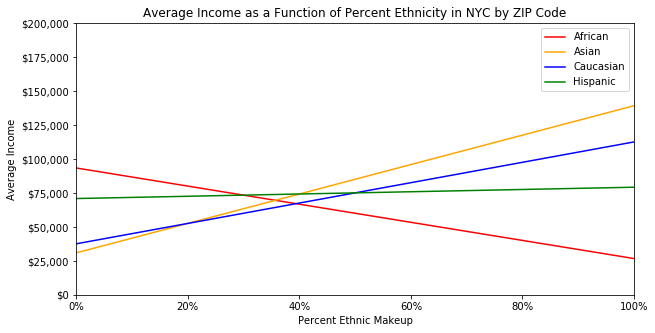

   Ethnicity  Std. Error p-value
0    African     0.16014  <2e-16
1      Asian     0.17214  <2e-16
2  Caucasian     0.18010  <2e-16
3   Hispanic     0.15142  <2e-16


In [142]:
# Perform the test.
perform_test()

Let's run this show!

/home/gary/PycharmProjects/NYC_Study/NYC/Demographic_Statistics_By_Zip_Code.csv
New York file already exists...
New York City file already exists...


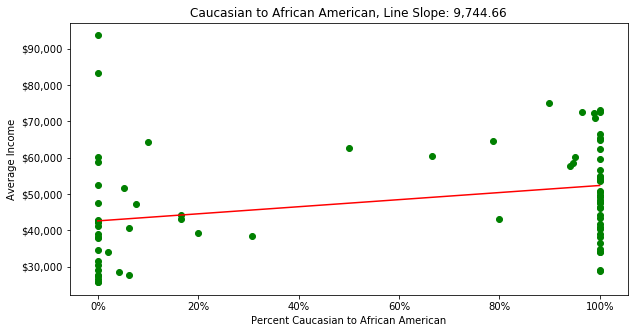

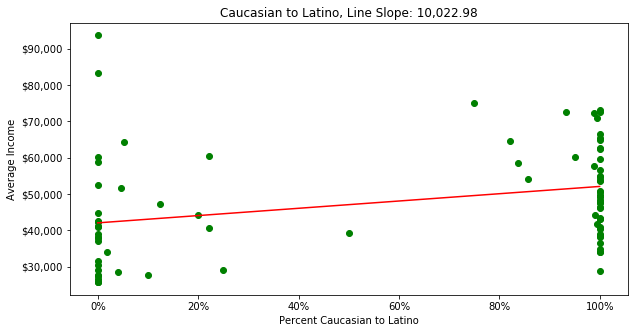

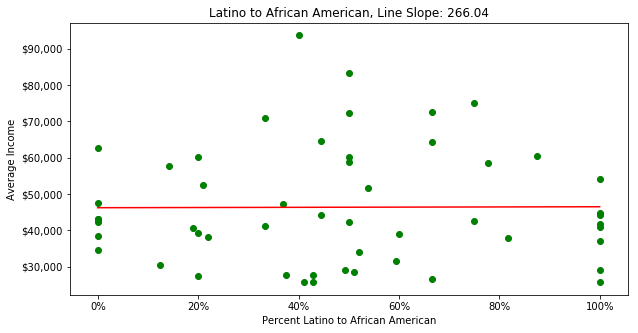

In [143]:
# Run the study.

run_study()